In [1]:
from src.data_structures.instance import Instance
from src.solvers.ZeroReductor.DLHEU2 import DHEU
from src.solvers.ZeroReductor.solver import features
from src.data_structures.features import *
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /build/python-pytorch/src/pytorch-opt/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2

validation_data_folder = Path("validation_data")
training_data_folder = Path("training_data")

In [3]:
key= lambda x: x.n_items
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key=key)

evaluation_instances = list(iter(map(Instance.from_file,validation_data_folder.iterdir())))
evaluation_instances.sort(key=key)




In [4]:
heu = DHEU(features)

In [5]:
#Este bloque se ejecuta manualmente tantas veces se necesite
for i in range(10):
    loss = []
    for epoch, instance in enumerate(instances):
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0: #Si la instancia no tiene solucion, no se usa :D (Las instancias mas pequeñas tienen ese riesgo)
            continue
        heu.optimizer.zero_grad()
        total_loss = 0
        y_pred = heu.net(x)
        batch_loss = heu.criterion(y_pred,y)
        batch_loss.backward()
        heu.optimizer.step()
        total_loss += batch_loss.item()
        loss.append((total_loss/2,instance))
        sys.stdout.write(f'\rEpoch {epoch},Presicion {1-(total_loss/2)} {str(instance)}')
        sys.stdout.flush()

Epoch 284,Presicion 0.7645595522049314 Instance(147,51,#8789690631165)Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-21
Epoch 2497,Presicion 0.9499431301817491 Instance(2500,50,#8789689321397)3)

In [6]:
#heu.save(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2.model"))

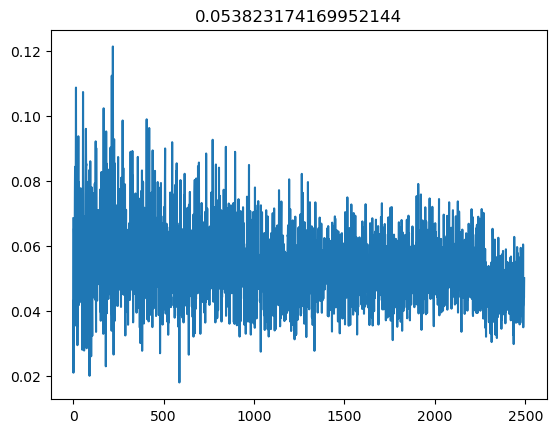

In [7]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(loss))],[i[0] for i in loss])
plt.title(np.average([i[0] for i in loss]))
plt.savefig("network_loss.png")

In [8]:
for tupla in loss[:2000]:
    print(tupla[0],str(tupla[1]))

0.0685004669640466 Instance(100,23,#8789801750777)
0.02099436136894921 Instance(100,40,#8789794646581)
0.04321353884048859 Instance(100,62,#8789794281709)
0.04011753615472444 Instance(100,88,#8789792495613)
0.06534438343855724 Instance(100,26,#8789792246589)
0.0596197321220327 Instance(100,97,#8789793264429)
0.04648159204977503 Instance(100,82,#8789789508605)
0.050231841025518066 Instance(100,79,#8789788849149)
0.0662701563895333 Instance(100,90,#8789788061693)
0.07681651462974531 Instance(100,94,#8789787512829)
0.08437433439044426 Instance(100,90,#8789786791917)
0.058837257579470864 Instance(100,65,#8789786001389)
0.036977050763596385 Instance(100,90,#8789785151485)
0.058942817476910124 Instance(100,80,#8789784360957)
0.08757405228861895 Instance(100,87,#8789783639021)
0.10874354538642392 Instance(100,70,#8789782849517)
0.07817325304147228 Instance(100,54,#8789800119725)
0.03540201466651276 Instance(100,71,#8789781210109)
0.037619587905498596 Instance(100,81,#8789780489197)
0.09034241

Presicion 90.155%
STD 1.891%


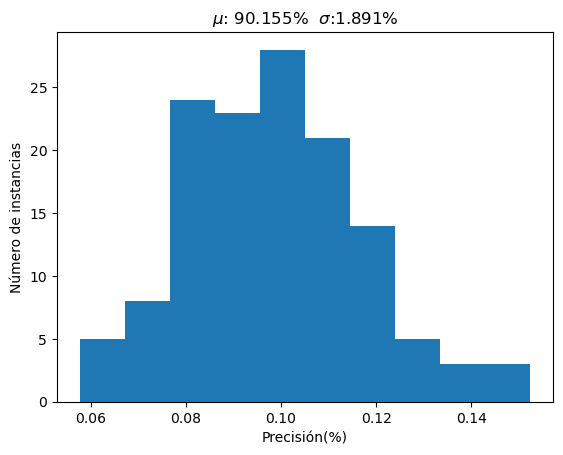

In [9]:
heu = DHEU(features)
heu.load(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2.model"))
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")
plt.title(fr"$\mu$: {np.round(precision,3)}%  $\sigma$:{np.round(desviacion_estandar,3)}%")
plt.hist(losses)
plt.ylabel("Número de instancias")
plt.xlabel("Precisión(%)")
plt.savefig("network_precision.png")

(array([825., 397., 375., 390., 235.,  79.,  74.,  57.,  65.,   0.,   0.,
         0.,   0.,   0.,   1.]), array([ 100.,  260.,  420.,  580.,  740.,  900., 1060., 1220., 1380.,
       1540., 1700., 1860., 2020., 2180., 2340., 2500.]), <BarContainer object of 15 artists>)


(100.0, 1500.0)

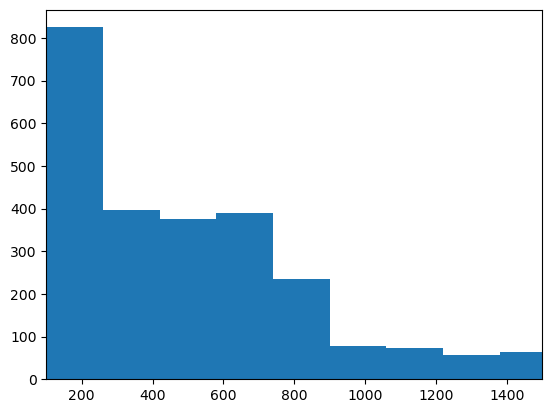

In [ ]:

a = plt.hist([instance.n_items for instance in instances],bins=15)
print(a)
plt.xlim(100,1500)